# Neural CA

In this notebook you can train a CA that converges to a given image, like in the Growing Neural Cellular Automata paper

In [1]:
import torch
from torchvision.io import read_image, ImageReadMode
import torchvision.transforms as T

import pylab as pl

from src import *

In [2]:
N_CHANNELS = 16        # Number of CA state channels
TARGET_PADDING = 8    # Number of pixels used to pad the target image border
TARGET_SIZE = 40       # Size of the target emoji
IMAGE_SIZE = TARGET_PADDING+TARGET_SIZE
BATCH_SIZE = 4
POOL_SIZE = 512
CELL_FIRE_RATE = 0.5
N_ITERS = 50

torch.backends.cudnn.benchmark = True  # Speeds up training

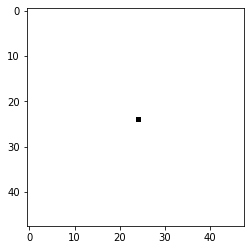

In [3]:
# Starting state

def generator(n, device):
    return make_seed(n, N_CHANNELS-1, IMAGE_SIZE, alpha_channel=3, device=device)

pool = SamplePool(POOL_SIZE, generator)
imshow(pool[0])

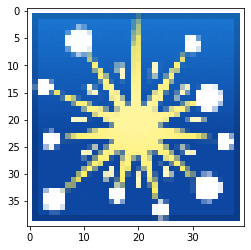

In [4]:
# Imports the target emoji
target = read_image("images/firework.png", ImageReadMode.RGB_ALPHA).float()
target = T.Resize((TARGET_SIZE, TARGET_SIZE))(target)
target = RGBAtoFloat(target)

imshow(target)

In [5]:
# Define the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

target = target.to(device)
model = NeuralCA(N_CHANNELS, device)

In [6]:
# Load a pretrained model
model.load("Pretrained_models/Virus/Virus lorenzo/firework_growing_64_96.pt")

Successfully loaded model!


In [7]:
L_target = NCALoss(pad(target, TARGET_PADDING), alpha_channels=[3])

L_dead = NCALoss(torch.zeros([4, 48, 48]).cuda(), alpha_channels=[3])

criterion = CombinedLoss([L_target, L_dead], [ConstantWeight(64, 96), ConstantWeight(160, np.inf)])

## Train the model

In [8]:
wandb.init(mode="disabled")

In [9]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[40, 80], gamma=0.3)

# Change kind in "growing" to train for growing, "persistent" to train for persistence
model.train_CA(optimizer, criterion, pool, batch_size=8, n_epochs=20, scheduler=scheduler,
               kind="persist", skip_damage=2, skip_update=1, n_max_losses=4,
               evolution_iters=96)

epoch: 20
avg loss: 0.022533186353030032


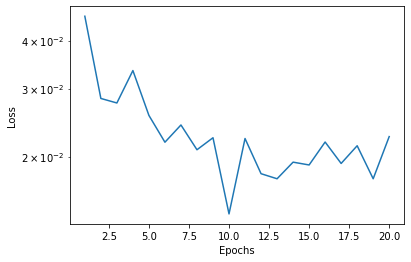

In [10]:
# Plot the losses
model.plot_losses()

In [ ]:
# Save a model
model.save("my_model.pt")

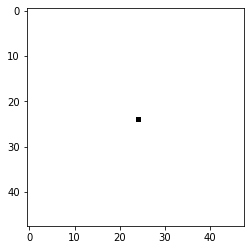

In [13]:
# A damaged image
image, idx = pool.sample(1)
imshow(image[0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


loss: 


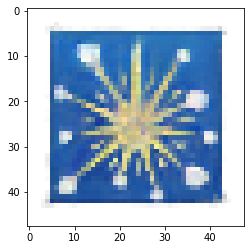

In [14]:
# After 200 iters the CA perfectly corrects it
x = model.evolve(image.cuda(), 96)
print("loss: ")
imshow(x[0])